In [5]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

# clustimage
from clustimage import Clustimage

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, jaccard_score,\
                            f1_score, precision_recall_curve,\
                            confusion_matrix, ConfusionMatrixDisplay,\
                            silhouette_score, mutual_info_score

# My packages
from tools import show_results_frecuencies as show_results

In [6]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# Classes
class1 = [0, 8, 32, 40, 128, 136, 160, 168]
class2 = [
          1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19, 
          23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38, 
          42, 43, 44, 46, 50, 51, 56, 57, 58, 62, 72, 73, 74, 
          76, 77, 78, 94, 104, 108, 130, 132, 134, 138, 140, 
          142, 152, 154, 156, 162, 164, 170, 172, 178, 184, 
          200, 204, 232
        ]
class3 = [18, 22, 30, 45, 60, 90, 105, 122, 126, 146, 150]
class4 = [41, 54, 106, 110]

In [7]:
def getPics(class_rules, samples_dir, n_samples_per_rule=None):
    class_imgs = []

    for r in class_rules:
        imgs_dir = samples_dir + f'rule_{str(r)}/'
        imgs_temp = [imgs_dir + f for f in os.listdir(imgs_dir)]
        class_imgs += imgs_temp[:n_samples_per_rule] # class balancing
    return class_imgs

c1_img_list = getPics(class1, inp_img_dir, 156)
c2_img_list = getPics(class2, inp_img_dir, 19)
c3_img_list = getPics(class3, inp_img_dir, 113)
c4_img_list = getPics(class4, inp_img_dir, 312)

In [8]:
files_target = [np.full(len(c1_img_list), 1), 
         np.full(len(c2_img_list), 2), 
         np.full(len(c3_img_list), 3), 
         np.full(len(c4_img_list), 4), 
         ]
[x.shape[0] for x in files_target]

[1248, 1235, 1243, 1248]

In [9]:
# Data selection

c1_x = c1_img_list.copy()
c2_x = c2_img_list.copy()
c3_x = c3_img_list.copy()
c4_x = c4_img_list.copy()

c1_y = files_target[0].copy()
c2_y = files_target[1].copy()
c3_y = files_target[2].copy()
c4_y = files_target[3].copy()

In [10]:
c_x = np.array(c1_x+c2_x+c3_x+c4_x)
c_y = np.concatenate((c1_y,c2_y,c3_y,c4_y))

In [11]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)
print(dataset.shape)
dataset.head(3)

(4974, 2)


,img,class
935,./samples/rule_136/136_000_0100_9210.png,1
953,./samples/rule_160/160_000_0068_9927.png,1
2530,./samples/rule_18/18_000_0008_6627.png,3


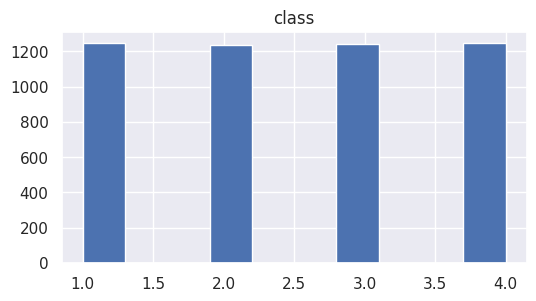

In [12]:
dataset.hist(figsize=(6,3))
plt.show()

In [13]:
cl_pca = Clustimage(method='pca',
                    params_pca={'n_components': 0.95, 'random_state': 42})

In [14]:
# clustimage object parameters

cluster='agglomerative'
evaluate='silhouette'
metric='euclidean'
linkage='ward'
min_clust=3
max_clust=6
cluster_space='low'

In [15]:
results = cl_pca.fit_transform(dataset['img'].values,
                               cluster=cluster,
                               evaluate=evaluate,
                               metric=metric,
                               linkage=linkage,
                               min_clust=min_clust,
                               max_clust=max_clust,
                               cluster_space=cluster_space)

[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 4974/4974 [00:02<00:00, 1846.78it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [616] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=4974, features=616
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [low] feature space of the [tsne] coordinates.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (4974, 2) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [5].
[clusteval] >Fin.


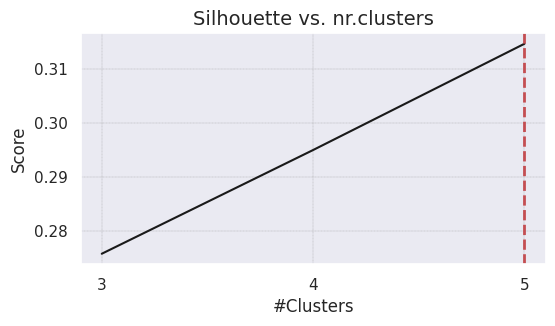

(<Figure size 600x300 with 1 Axes>,
 <Axes: title={'center': 'Silhouette vs. nr.clusters'}, xlabel='#Clusters', ylabel='Score'>)

In [16]:
# Silhouette plots
cl_pca.clusteval.plot(figsize=(6,3))

[clusteval] >Estimated number of n_clusters: 5, average silhouette_score=0.315


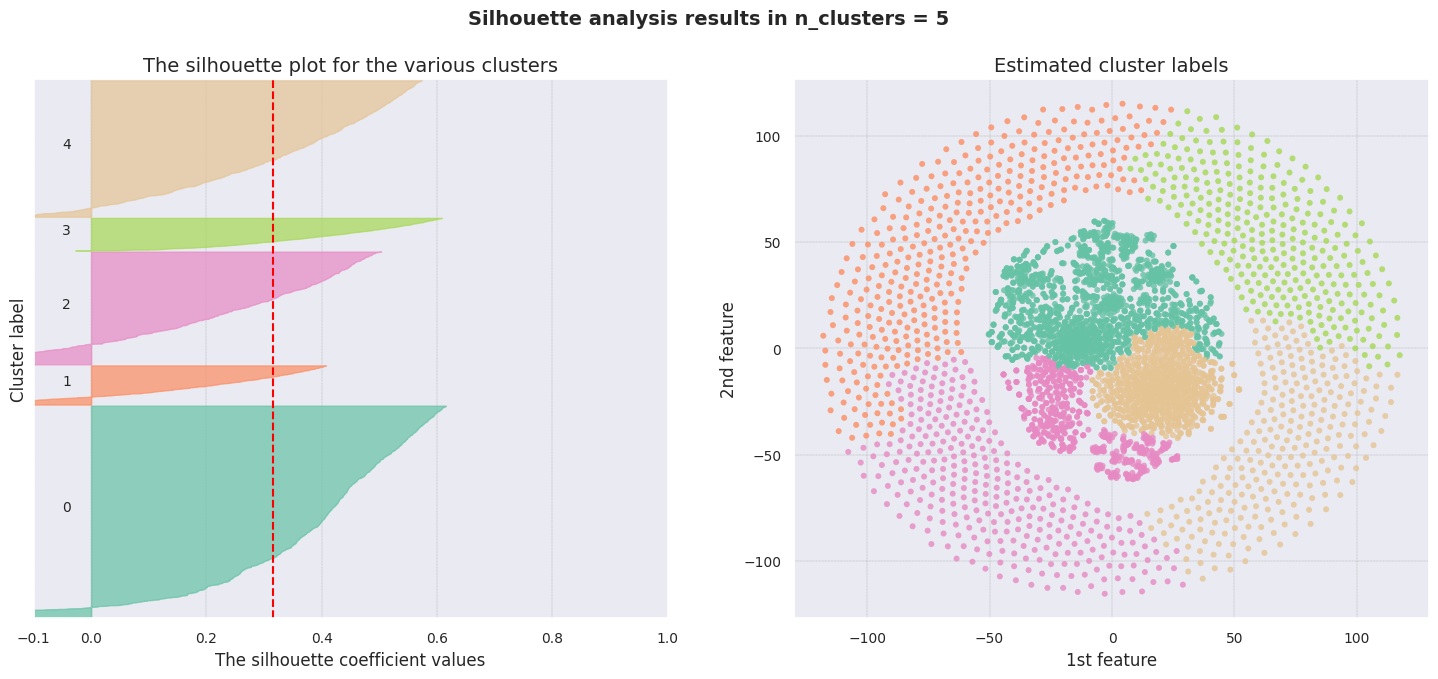

(<Figure size 1800x700 with 2 Axes>,
 <Axes: title={'center': 'The silhouette plot for the various clusters'}, xlabel='The silhouette coefficient values', ylabel='Cluster label'>,
 <Axes: title={'center': 'Estimated cluster labels'}, xlabel='1st feature', ylabel='2nd feature'>)

In [17]:
cl_pca.clusteval.scatter(cl_pca.results['xycoord'],figsize=(6,3))

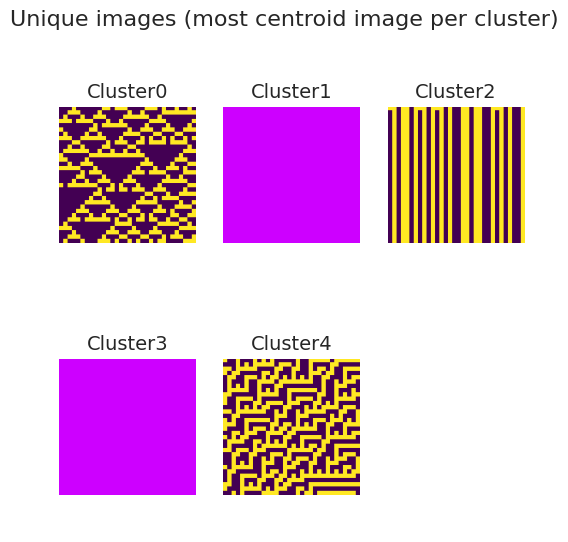

In [18]:
# Plot unique image per cluster
cl_pca.plot_unique(img_mean=False, figsize=(6,6))

In [19]:
# Plot unique image per cluster
# cl_pca.plot_unique(figsize=(6,6))

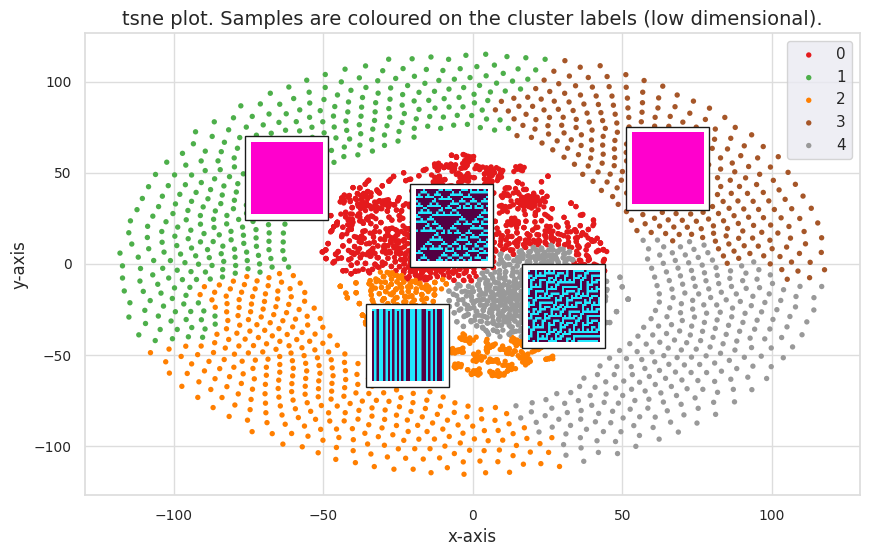

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'tsne plot. Samples are coloured on the cluster labels (low dimensional).'}, xlabel='x-axis', ylabel='y-axis'>)

<Figure size 640x480 with 0 Axes>

In [20]:
# Scatterplot
cl_pca.scatter(zoom=0.4, img_mean=False, figsize=(10,6))

In [21]:
# Plot images per cluster 
# cl_pca.plot(cmap='binary')

In [22]:
names, labels = cl_pca.results['pathnames'],\
                cl_pca.results['labels']

results_df = pd.DataFrame(data={'img':names,
                                'y_pred':labels})
results_df.head(3)

,img,y_pred
0,./samples/rule_136/136_000_0100_9210.png,2
1,./samples/rule_160/160_000_0068_9927.png,4
2,./samples/rule_18/18_000_0008_6627.png,0


In [23]:
save_path = './results/'

file_name = f'{cluster}_{evaluate}_{metric}.csv'

results_df.to_csv(save_path + file_name, index=False)

In [24]:
np.unique(c_y), np.unique(labels)

(array([1, 2, 3, 4]), array([0, 1, 2, 3, 4], dtype=int32))

In [25]:
scores = {
    'accuracy_score' : {
        'results': accuracy_score(c_y, labels)
    },
    'jaccard_score':{
        'results':jaccard_score(c_y, labels, average="micro")
    },
    'f1_score':{
        'results': f1_score(c_y, labels, average='micro')
    },
    'mutual_info_score':{
        'results': mutual_info_score(c_y, labels)
    },
    
}

results_df = pd.DataFrame.from_dict(scores)
results_df.T

,results
accuracy_score,0.146562
jaccard_score,0.079076
f1_score,0.146562
mutual_info_score,0.001634


In [26]:
n_classes = len(np.unique(labels))
show_results(labels, n_classes, 'y_train', 10)